# Q1

### Import libraries

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow_datasets as tfds
import tensorflow as tf

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils import to_categorical
from keras.models import Model
from keras.optimizers import SGD
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, ZeroPadding2D
from keras.applications.vgg16 import VGG16

In [2]:
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

In [3]:
# Check if GPU is available
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

# Allocate GPU memory
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

GPU found
1 Physical GPUs, 1 Logical GPUs


# II: METHOD

## B: Image Processing

### Load Dataset

In [4]:
ds, ds_info = tfds.load('eurosat/rgb', split='train', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/2.0.0.incompleteWJSY0J/eurosat-train.tfrecord*...:   0%|      …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


In [5]:
images = []
labels = []

for img in ds:
  image = img['image']
  label = img['label']


  images.append(image)
  labels.append(label.numpy())

### Save and display sample of each category

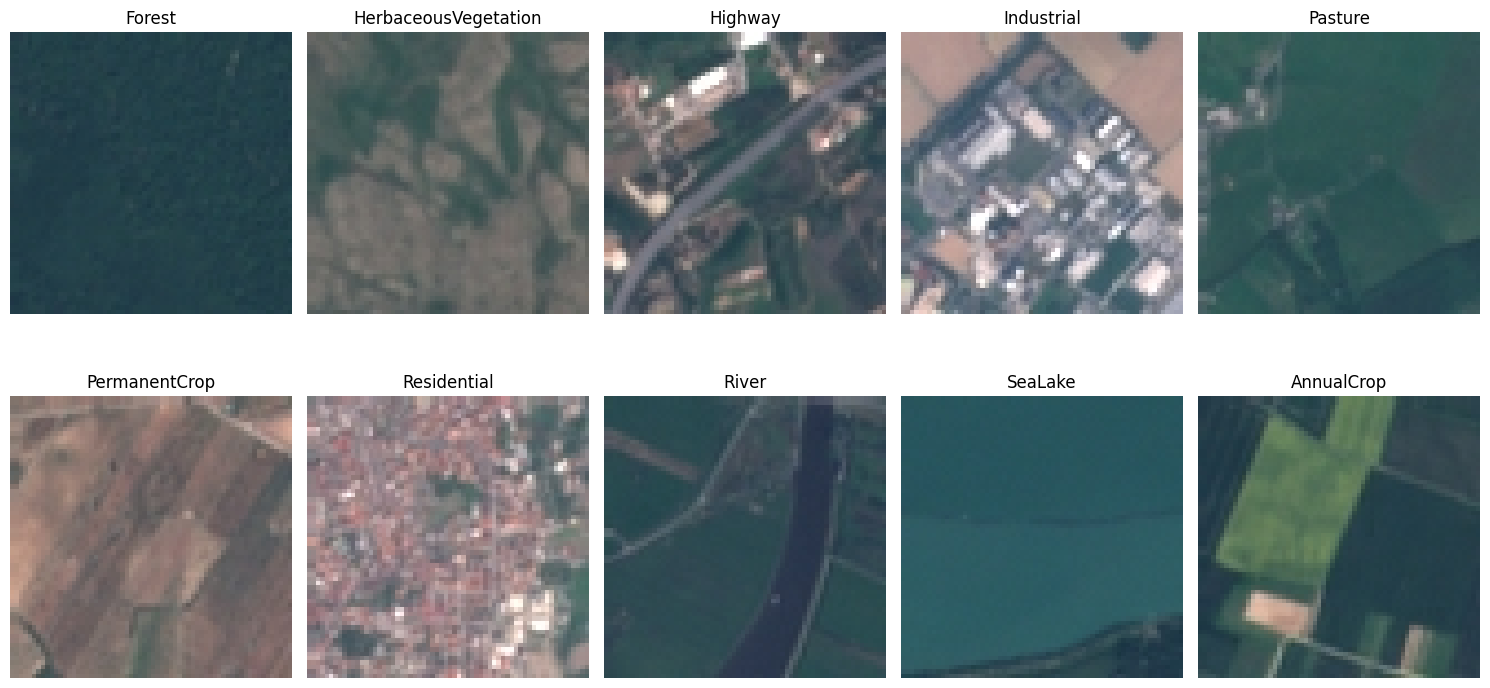

In [6]:
num_categories = len(set(labels))

class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

category_images = [[] for i in range(num_categories)]

for idx, label in enumerate(labels):
  category_images[label-1].append(images[idx])

# Show one image from each category
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 8))
for i, img in enumerate(category_images):
  ax = axes[int(i/5), i%5]
  ax.imshow(img[0], cmap='gray')
  ax.set_title(class_names[(i+1)%10])
  ax.axis('off')
plt.tight_layout()
plt.show()

### Preprocess each image of dataset

In [7]:
modified_images = []

for indx, image in enumerate(images):

  # Resize the image to (64, 64, 3)
  if image.shape != (64, 64, 3):
    image = cv2.resize(image.numpy(), (64, 64, 3))
    
  # Scale the image
  image = np.divide(image, 255.0)

  modified_images.append(image)

modified_images = np.array(modified_images)
labels = np.array(labels)

### Split dataset to training, validation and test sets

In [8]:
X_train, X_test, y_train, y_test = train_test_split(modified_images, labels, test_size=0.2, stratify=labels)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(f'Train Shape: {X_train.shape}')
print(f'Test Shape: {X_test.shape}')

Train Shape: (21600, 64, 64, 3)
Test Shape: (5400, 64, 64, 3)


## A: Modeling

### Use transfer learning
Use transfer learning to use VGG16 weights and biases

In [9]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(64, 64, 3))
base_model.trainable = False
base_model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [10]:
x = base_model.output
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1000, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_categories, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

## C, D: Training and Testing

In [11]:
def f1_score_metric(y_true, y_pred):
    return f1_score(tf.argmax(y_true, axis=1), tf.argmax(y_pred, axis=1), average='macro')

sgd = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=sgd, loss='categorical_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.Precision()])

# train the model on your dataset
with tf.device('/device:GPU:0'):
  history = model.fit(X_train, y_train, batch_size=32, epochs=40, validation_data=(X_test, y_test))

Epoch 1/40
675/675 [==============================] - 30s 29ms/step - loss: 1.1831 - accuracy: 0.5699 - precision: 0.7494 - val_loss: 0.7498 - val_accuracy: 0.7470 - val_precision: 0.8442
Epoch 2/40
675/675 [==============================] - 15s 22ms/step - loss: 0.8168 - accuracy: 0.7042 - precision: 0.7899 - val_loss: 0.6731 - val_accuracy: 0.7561 - val_precision: 0.8155
Epoch 3/40
675/675 [==============================] - 15s 22ms/step - loss: 0.7188 - accuracy: 0.7455 - precision: 0.8101 - val_loss: 0.5618 - val_accuracy: 0.8076 - val_precision: 0.8640
Epoch 4/40
675/675 [==============================] - 17s 25ms/step - loss: 0.6550 - accuracy: 0.7674 - precision: 0.8274 - val_loss: 0.5356 - val_accuracy: 0.8237 - val_precision: 0.8679
Epoch 5/40
675/675 [==============================] - 17s 25ms/step - loss: 0.6204 - accuracy: 0.7821 - precision: 0.8325 - val_loss: 0.5224 - val_accuracy: 0.8248 - val_precision: 0.8631
Epoch 6/40
675/675 [==============================] - 17s 25

# III: EXPERIMENTAL RESULTS AND ANALYSIS

## A: Expreimental Result

### Show classification report and confusion matrix

In [12]:
y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# compute and print classification report and confusion matrix
print('Classification Report:')
print(classification_report(y_test_classes, y_pred_classes))
print('Confusion Matrix:')
print(confusion_matrix(y_test_classes, y_pred_classes))


169/169 [==============================] - 3s 15ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       600
           1       0.92      0.89      0.91       600
           2       0.90      0.87      0.88       600
           3       0.75      0.86      0.80       500
           4       0.93      0.95      0.94       500
           5       0.71      0.90      0.80       400
           6       0.90      0.75      0.82       500
           7       0.94      0.95      0.94       600
           8       0.83      0.76      0.79       500
           9       0.96      0.93      0.94       600

    accuracy                           0.88      5400
   macro avg       0.87      0.87      0.87      5400
weighted avg       0.88      0.88      0.88      5400

Confusion Matrix:
[[531   2   3  12   0  20   8   0  19   5]
 [  0 536   3   0   0  40   0   0   4  17]
 [  0  14 520  13   0  21  13  12   7   0]
 [ 12   0  10 4

In [13]:
def plot_accuracy(history):
  
    sns.set_style("darkgrid")
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()    

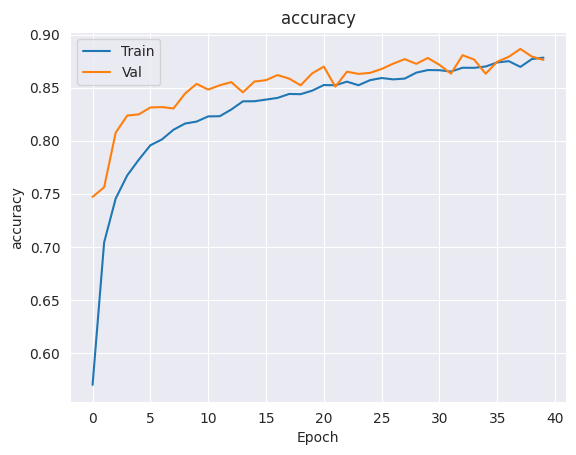

In [14]:
plot_accuracy(history)

In [15]:
def plot_loss(history):
  
    sns.set_style("darkgrid")
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()  

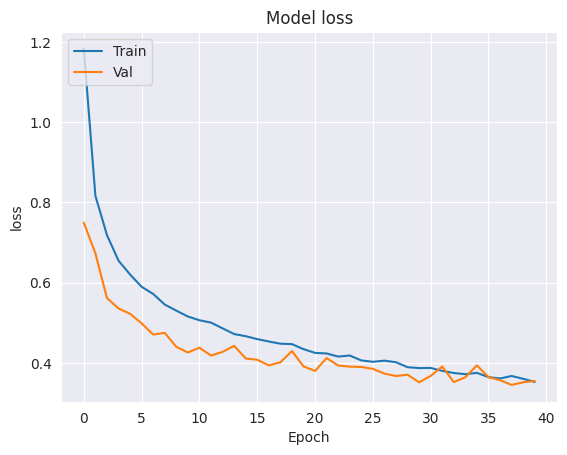

In [16]:
plot_loss(history)

In [17]:
def plot_precision(history):
  
    sns.set_style("darkgrid")
    plt.plot(history.history['precision'])
    plt.plot(history.history['val_precision'])
    plt.title('precision')
    plt.ylabel('precision')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()  

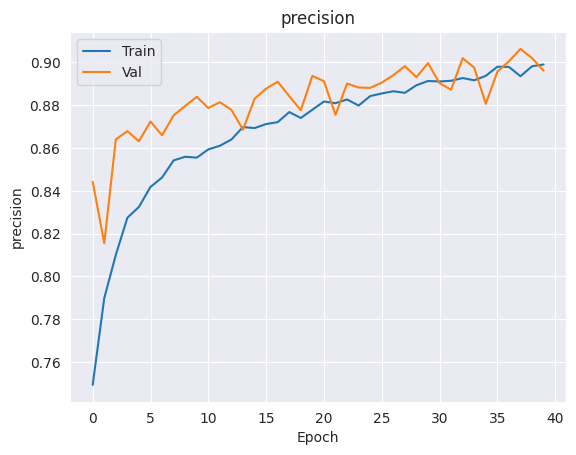

In [18]:
plot_precision(history)